## Install and import dependencies

[TensorFlow Datasets](https://www.tensorflow.org/datasets/), an API that simplifies downloading and accessing datasets, and provides several sample datasets to work with.

In [0]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 942kB 3.5MB/s 


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

W0727 08:05:28.168102 140199879030656 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [0]:
print(tf.__version__)

1.14.0


In [0]:
tf.enable_eager_execution()

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Import the Fashion MNIST dataset

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

W0727 08:06:02.900033 140199879030656 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

### Explore the data

In [0]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples: 10000


## Preprocess the data

In [0]:
# Apply the normalization to each element in the train and test datasets
def normalize(images, labels):
    return tf.cast(images, tf.float32) / 255, labels

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

### Explore the precessed data

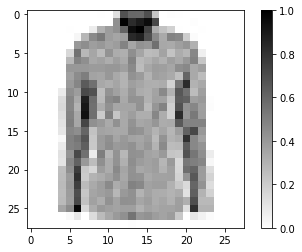

In [22]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

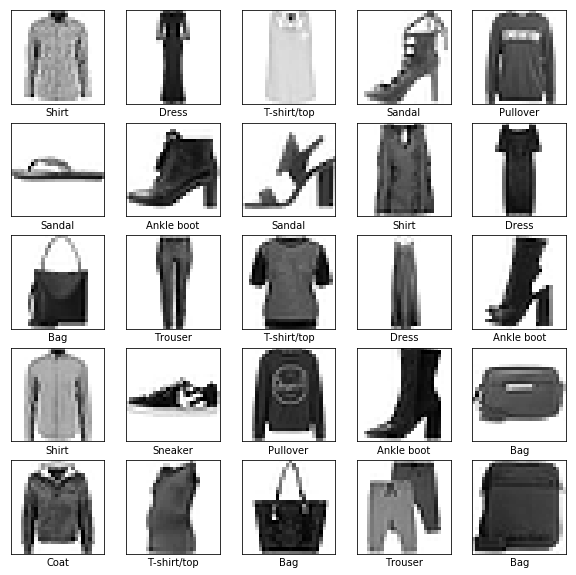

In [25]:
plt.figure(figsize=(10,10))
i = 0
for image, label in test_dataset.take(25):
    image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Setup the Layers

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Compile the model

Before the model is ready for traning, it needs a few more settings.

+ Loss function
+ Optimizer
+ Metrics - Used to monitor the traning and testing steps.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [29]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 25s 13ms/step - loss: 0.4941 - acc: 0.8253
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3788 - acc: 0.8634
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3339 - acc: 0.8777
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3157 - acc: 0.8831
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2959 - acc: 0.8900


## Evaluate accuracy

In [30]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples / 32))
print("Accuracy on test dataset: ", test_accuracy)

313/313 [==============================] - 2s 6ms/step - loss: 0.3440 - acc: 0.8772
Accuracy on test dataset:  0.8772


## Make predictions and explore

In [0]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [32]:
predictions.shape

(32, 10)

In [33]:
predictions[0]

array([2.1147041e-05, 8.3376662e-08, 4.7450750e-03, 1.3530551e-04,
       5.4056972e-02, 1.0157337e-06, 9.4102061e-01, 9.8832520e-10,
       1.9746863e-05, 4.1578230e-09], dtype=float32)

In [38]:
print(np.argmax(predictions[0]) == test_labels[0])

True


In [0]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color = color)

In [0]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    this_plot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    this_plot[predicted_label].set_color('red')
    this_plot[true_label].set_color('blue')

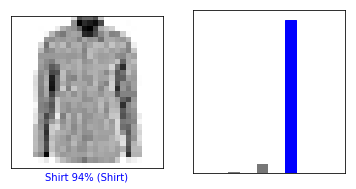

In [43]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

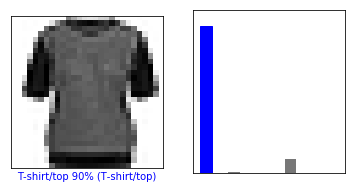

In [44]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

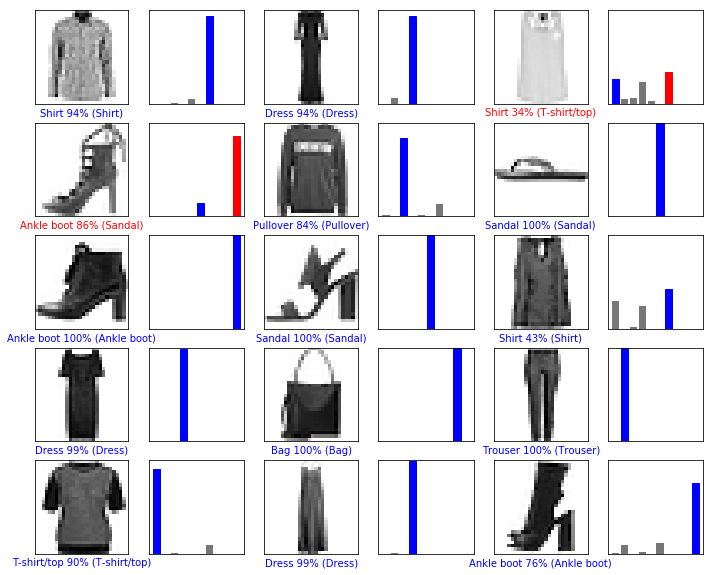

In [46]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols << 2, num_rows << 1))
for i in range(num_images):
    plt.subplot(num_rows, num_cols << 1, i << 1 | 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, num_cols << 1, (i << 1) + 2)
    plot_value_array(i, predictions, test_labels)

Finally, we can use the trained model to make a prediction about a single image.